<h3>Подключение необходимых библиотек и модулей</h3>

In [1]:
import pandas as pd
from lightgbm import LGBMRegressor, plot_tree
from sklearn.model_selection import train_test_split
from evaluation import (
    evaluate_regression,
    plot_regression,
    residuals_histogram,
    calculate_importance_gains,
    plot_feature_importances,
)

<h3>Загрузка данных из CSV</h3>

In [2]:
df = pd.read_csv("diamonds2.csv")
columns_mapping = {
    "carat": "Карат",
    "cut": "Огранка",
    "color": "Цвет",
    "clarity": "Чистота",
    "depth": "Глубина",
    "table": "Площадка",
    "price": "Цена",
    "x": "Длина",
    "y": "Ширина",
    "z": "Высота",
}
df.rename(columns=columns_mapping, inplace=True)
df

,Карат,Огранка,Цвет,Чистота,Глубина,Площадка,Цена,Длина,Ширина,Высота
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


<h3>Проверка на пропуски</h3>

In [3]:
df.isnull().sum()

Карат        0
Огранка      0
Цвет         0
Чистота      0
Глубина      0
Площадка     0
Цена         0
Длина        8
Ширина       7
Высота      20
dtype: int64

<h3>Удаление пропусков</h3>

In [4]:
df = df.dropna()
df

,Карат,Огранка,Цвет,Чистота,Глубина,Площадка,Цена,Длина,Ширина,Высота
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


<h3>Преобразование категориальных переменных</h3>

In [5]:
df = df.copy()

for column in df.select_dtypes(include="object"):
    df[column] = df[column].astype("category")

In [6]:
y = df["Цена"]
X = df.drop(columns=["Цена"])
X

,Карат,Огранка,Цвет,Чистота,Глубина,Площадка,Длина,Ширина,Высота
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


<h3>Разбиение выборки на тренировочную, тестовую и валидационную</h3>

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, shuffle=True, test_size=0.2, random_state=1
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    shuffle=True,
    test_size=0.5,
    random_state=1,
)

<h3>Обучение базовой модели</h3>

In [8]:
model = LGBMRegressor(
    n_jobs=-1,
    random_state=1,
    force_col_wise=True,
    importance_type="gain",
    verbose=-1,
).fit(X_train, y_train)

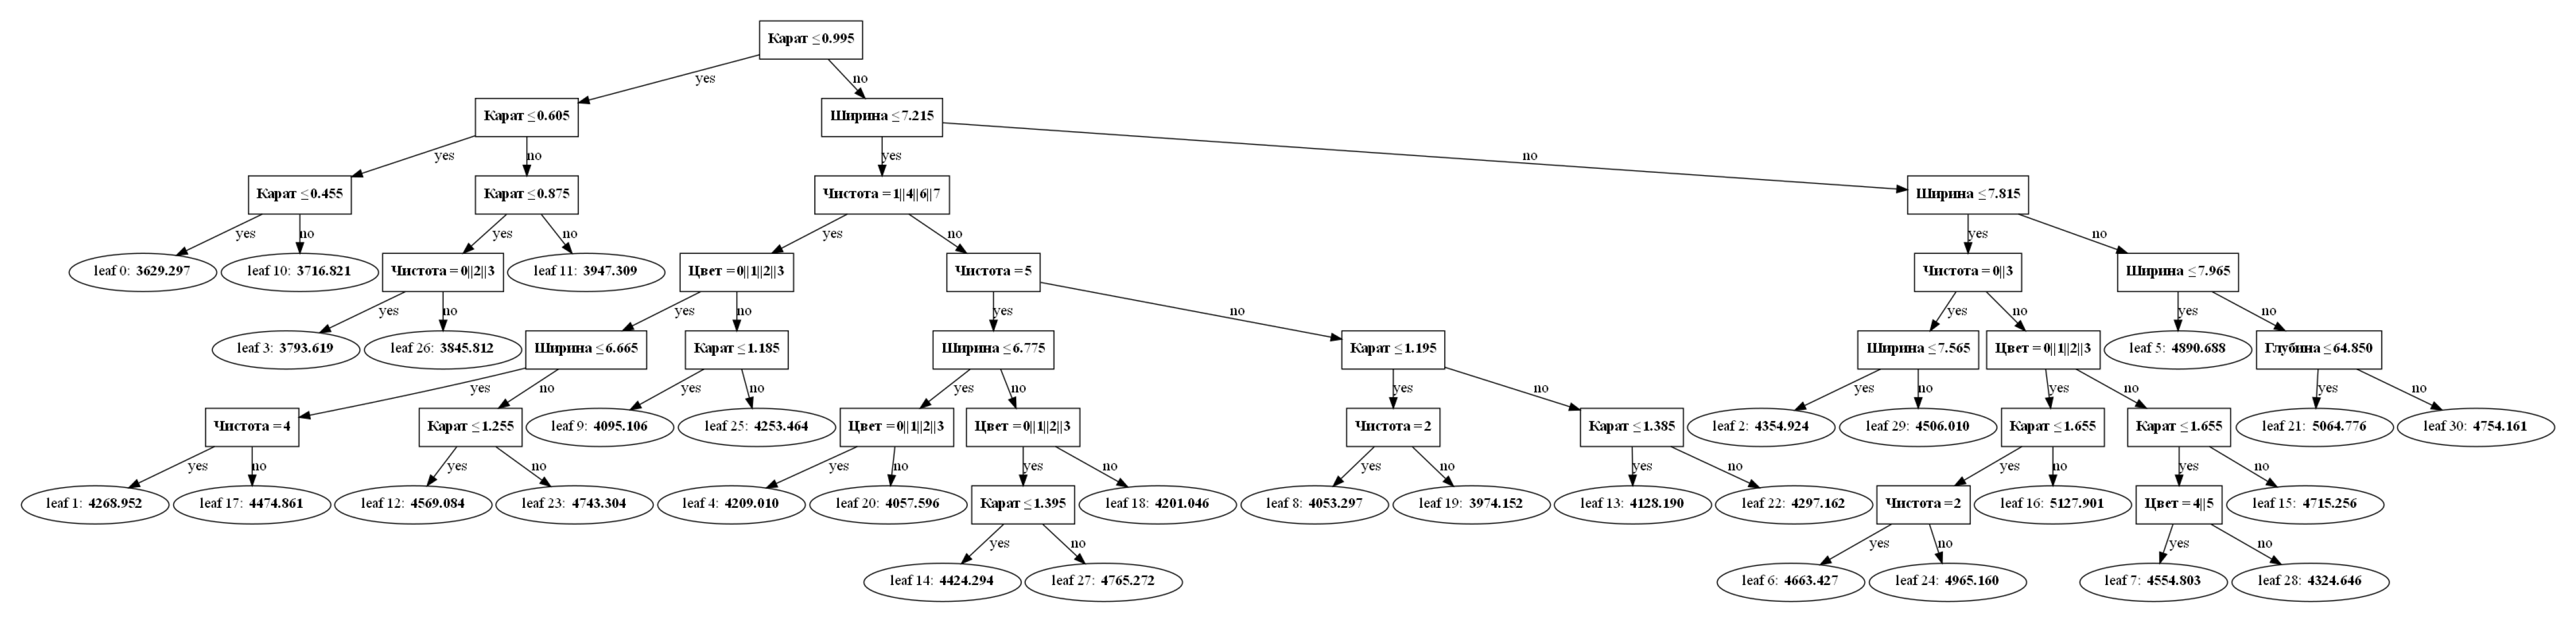

In [9]:
plot_tree(model, figsize=(19, 6), tree_index=0, orientation="vertical", dpi=300);

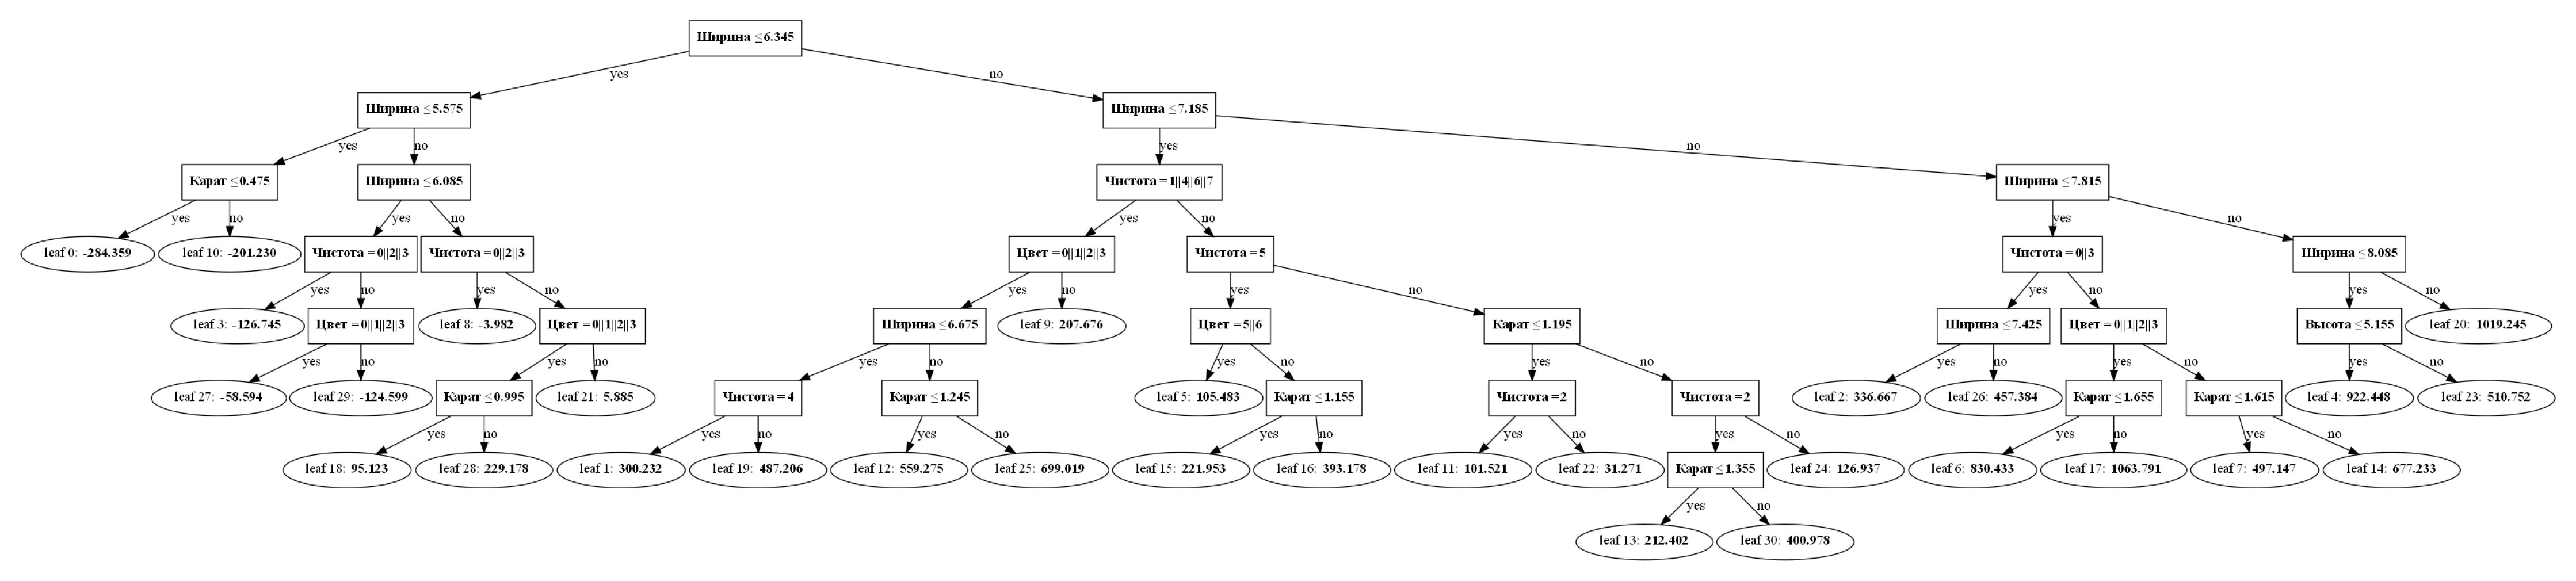

In [10]:
plot_tree(model, figsize=(19, 6), tree_index=1, orientation="vertical", dpi=300);

In [11]:
feature_importances_percent = calculate_importance_gains(model, X_train.columns)
feature_importances_percent

,information gain (%)
Ширина,48.513
Карат,39.170
Чистота,5.996
Высота,2.950
Цвет,2.703
Длина,0.352
Глубина,0.141
Огранка,0.118
Площадка,0.057


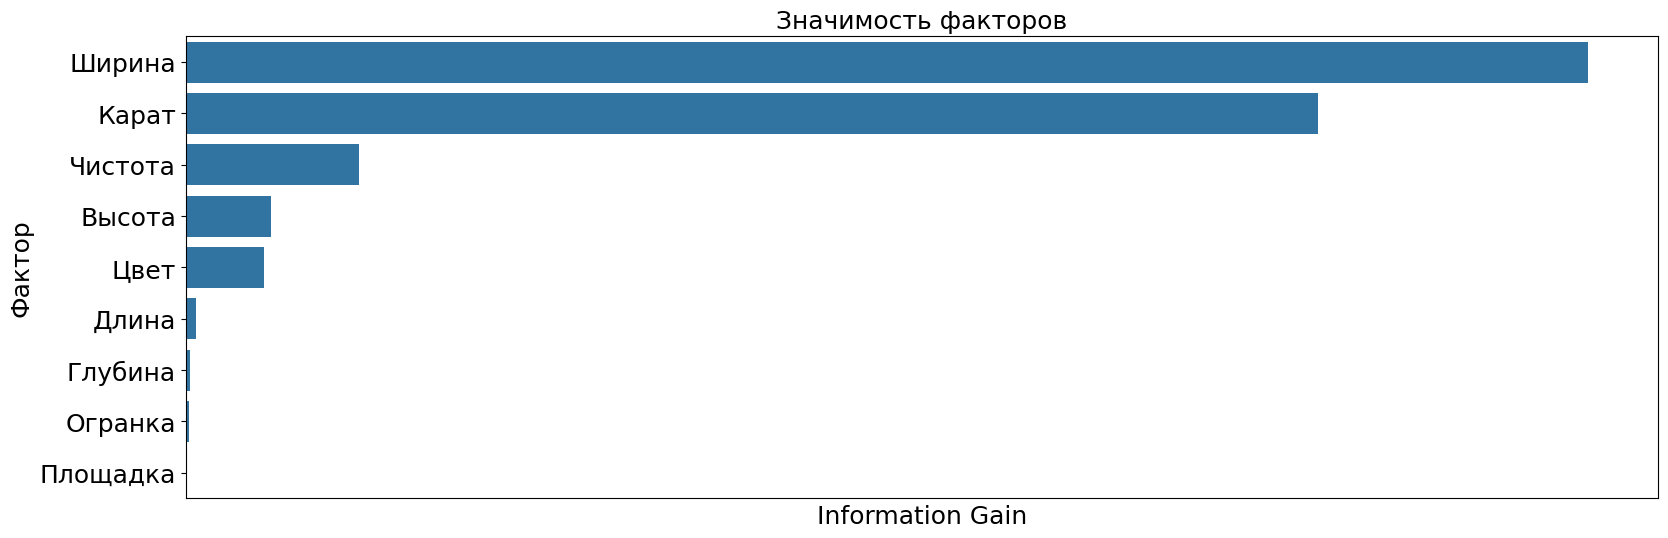

In [12]:
plot_feature_importances(feature_importances_percent)

<h3>Наиболее значимым фактором является Ширина. Из категориальных переменных - Чистота. Первые три фактора: Ширина, Карат и Чистота обеспечивают 93 % прироста информации для модели.</h3>

<h3>Оценка модели</h3>

In [13]:
y_pred_train = model.predict(X_train)
evaluate_regression(y_train, y_pred_train, len(X_train.columns))

RMSE равняется 477.079
MAE равняется 262.375
MAPE равняется 7.881 %
Adjusted R2 равняется 0.986


In [14]:
y_pred_val = model.predict(X_val)
evaluate_regression(y_val, y_pred_val, len(X_train.columns))

RMSE равняется 545.552
MAE равняется 280.782
MAPE равняется 8.208 %
Adjusted R2 равняется 0.980


<center><h3>Метрики качества базовой модели </h3>
<table>
  <tr>
    <td></td>
    <td><b>Train</b></td>
    <td><b>Validation</b></td>
  </tr>
  <tr>
    <td><b>RMSE</b></td>
    <td>477.079</td>
    <td>545.552</td>
  </tr>
  <tr>
    <td><b>MAE</b></td>
    <td>262.375</td>
    <td>280.782</td>
  </tr>
  <tr>
    <td><b>MAPE (%)</b></td>
    <td>7.881</td>
    <td>8.208</td>
  </tr>
  <tr>
    <td><b>R<sup>2</sup><sub>adjusted</sub></b></td>
    <td>0.986</td>
    <td>0.980</td>
  </tr>
</table></center>

<h3>Показатели на обучающей и валидационной выборке не сильно отличаются, отсутствует переобучение.</h3>

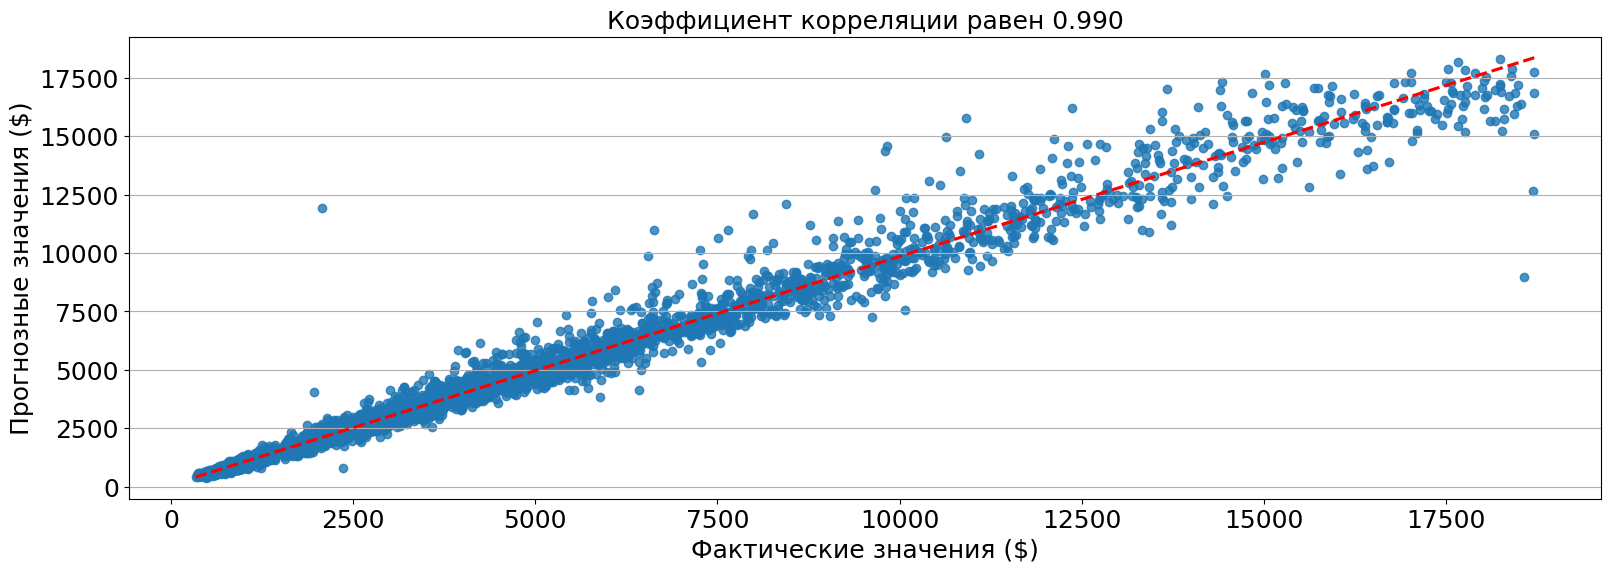

In [15]:
plot_regression(y_val.values, y_pred_val)

<h3>Коэффициент линейной корреляции Пирсона между фактическими и прогнозными значениями очень большой. Это также подтвержает, что модель хорошо справляется с прогнозами на валидационной выборке. Чем бриллиант дешевле, тем лучше модель прогнозирует его стоимость.</h3>

<h3>Анализ остатков модели на валидационной выборке</h3>

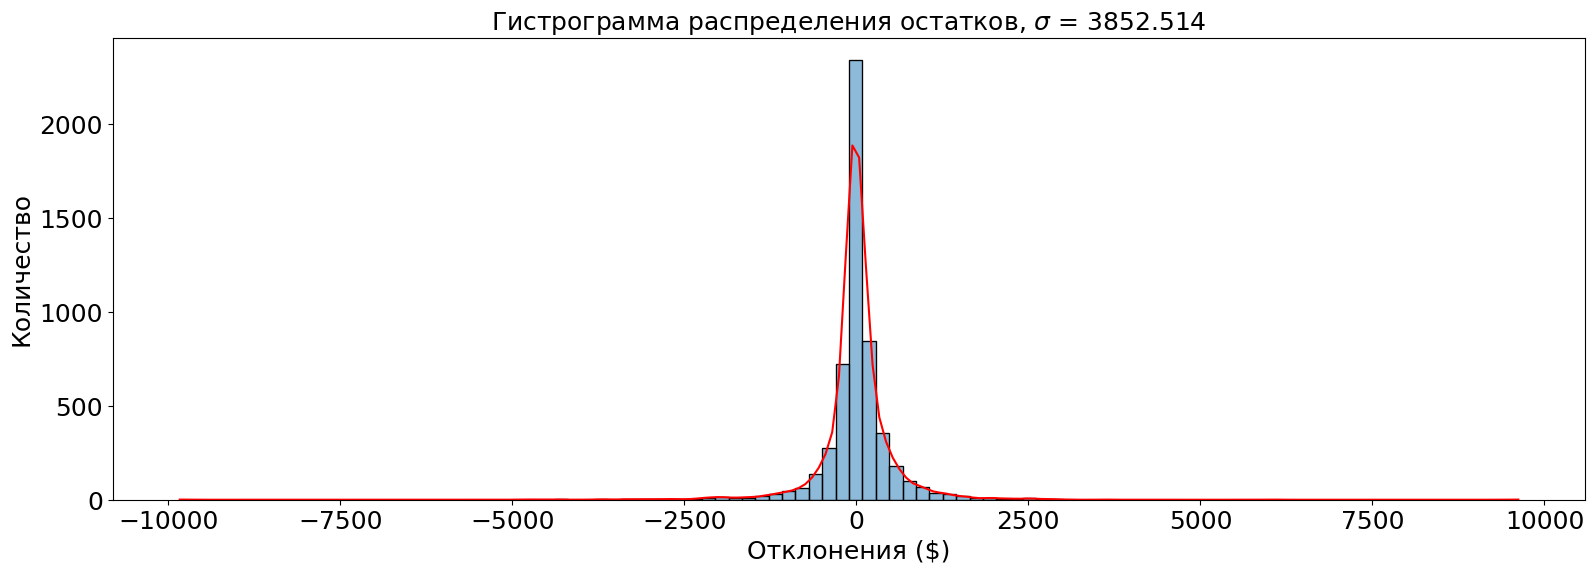

In [16]:
residuals_histogram(y_val, y_pred_val)

<h3>Отклонения не превышают 3 сигм и в основном находятся в окрестности нуля. Распределение остатков похоже на нормальное. Существуют объекты, на которых модель сильно ошибается - очень дорогие бриллианты</h3>